In [1]:
#Load in mnist dataset or download if not available
from pathlib import Path
import requests
import pickle
import gzip
import matplotlib.pyplot as plt
import numpy as np 
import torch
import math

DATA_PATH=Path("data")
PATH=DATA_PATH/"mnist"
PATH.mkdir(parents=True,exist_ok=True)
URL = "http://deeplearning.net/data/mnist/"
FILENAME = "mnist.pkl.gz"

if not (PATH / FILENAME).exists():
        content = requests.get(URL + FILENAME).content
        (PATH / FILENAME).open("wb").write(content)

with gzip.open((PATH/FILENAME).as_posix(),'rb') as f:
    ((x_train,y_train),(x_valid,y_valid),_)=pickle.load(f,encoding="latin-1")
   


(50000, 784)


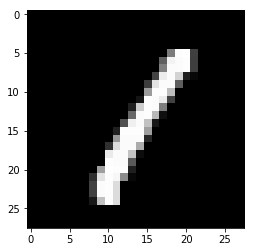

In [16]:

#Show a value to confirm it worked
plt.imshow(x_train[3].reshape((28,28)),cmap="gray")
print(x_train.shape)

In [3]:
x_train=torch.tensor(x_train,device='cuda')
y_train=torch.tensor(x_train,device='cuda')
x_valid=torch.tensor(x_train,device='cuda')
y_valid=torch.tensor(x_train,device='cuda')


In [27]:
y_valid.dtype

torch.float32

In [3]:
x_train.device

device(type='cpu')

In [2]:
#Apply tensor function to training and validation data
x_train, y_train, x_valid, y_valid = map(
    torch.tensor, (x_train, y_train, x_valid, y_valid)
)

In [4]:
#Validate what's in the training set
batches,dimensions=x_train.shape
print(f"Training set contains {batches} batches and {dimensions} dimensions each")

Training set contains 50000 batches and 784 dimensions each


In [4]:


def log_softmax(x): #Activation function
    return x-x.exp().sum(-1).log().unsqueeze(-1)
def model(xb): #Simple single layer model with logsoftmax activation
    return log_softmax(xb @ weights + bias)  #Takes batch * weights and runs it through act function
def nll(inp,target):
    return -inp[range(target.shape[0]),target].mean() #Overall loss
def accuracy(out,yb): #Accuracy
    preds=torch.argmax(out,dim=1)
    return (preds==yb).float().mean()

def get_batch(bs,x,y): #Function to pass the next batch, based on x_train, y_train
    nbatches=x.shape[0]//bs
    current_batch=0
    while current_batch<nbatches:
        yield x[current_batch*bs:(current_batch+1)*bs], y[current_batch*bs:(current_batch+1)*bs]
        current_batch+=1

In [6]:
#Initialize weights and biases and losses/accuracy arrays
device="cuda"
weights=torch.randn(784,10,device=device)/math.sqrt(784) 
weights.requires_grad_()
bias=torch.zeros(10,device=device,requires_grad=True)
loss_func=nll
losses=[]
acc=[]


In [8]:
#Create batch generator based on batch size and then pass into model until exhausted
batch_size=64
max_batches=x_train.shape[0]//batch_size
batches=get_batch(batch_size,x_train,y_train)
for i in range(max_batches):
    xb,yb=next(batches)
    preds=model(xb)
    loss=loss_func(preds,yb.type(torch.int))
    loss.backward()
    with torch.no_grad():
      weights-=weights.grad
      weights.grad.zero_()
    losses.append(loss)
    accu=accuracy(preds,yb)
    acc.append(accu)
    #print(loss)
    #print(accu)
plt.plot(losses)
plt.show()
plt.plot(acc)


IndexError: tensors used as indices must be long, byte or bool tensors

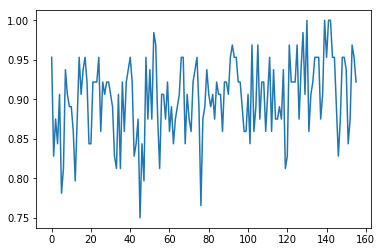

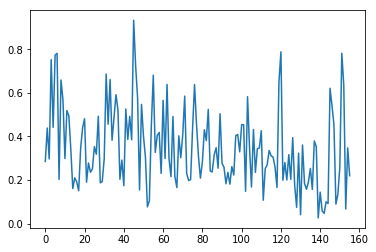

In [8]:
#See how we did by feeding against validation dataset
v_accu=[]
v_losses=[]

batch_size=64
max_batches=x_valid.shape[0]//batch_size
batches_v=get_batch(batch_size,x_valid,y_valid)

for i in range(max_batches):
    xv_b,yv_b=next(batches_v)
    preds=model(xv_b)
    vacc=accuracy(preds,yv_b)
    loss=loss_func(preds,yv_b)
    v_accu.append(vacc)
    v_losses.append(loss)
plt.plot(v_accu)
plt.show()
plt.plot(v_losses)



In [9]:
#Using NN Module
from torch.nn import functional as F
loss_func=F.cross_entropy #nll(logsoftmax(x))
def model_2(xb):
    return xb @ weights + bias
#Can see that both return the same value
#print(loss_func(model_2(xv_b),yv_b),accuracy(model_2(xb),yb))
#print(loss_func(model(xv_b),yv_b),accuracy(model(xb),yb))

In [5]:
from torch import nn 
from torch import optim
class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        #self.weights=nn.Parameter(torch.randn(784,10)/math.sqrt(784)) # Input Pixels, Possible Outputs 
        #self.bias=nn.Parameter(torch.zeros(10))
        self.lin1=nn.Linear(784,10)
   #     self.lin2=nn.Linear(1000,10)
        self.lr=.05
        self.opt=optim.SGD(self.parameters(),lr=self.lr)
    def forward(self,xb):
    #    x=self.lin1(xb)
        return self.lin1(xb)
        #return xb @ self.weights +self.bias
   

In [57]:
model.to('cuda')

RuntimeError: CUDA error: an illegal memory access was encountered

In [18]:
model=Mnist_Logistic()
model.to('cuda:0')

Mnist_Logistic(
  (lin1): Linear(in_features=784, out_features=10, bias=True)
)

In [176]:
accuracy(model(xb),yb)

tensor(0.0938)

In [12]:
y = torch.tensor([1., 2.]).cuda()

In [22]:
F.softmax

<function torch.nn.functional.softmax(input, dim=None, _stacklevel=3, dtype=None)>

In [31]:
batch_size=64
lr=.02
max_batches=x_train.shape[0]//batch_size
batches=get_batch(batch_size,x_train,y_train)
accu=[]
epochs=2
model=Mnist_Logistic()
model.to('cuda:0')
def fit():
   
    from torch.nn import functional as F
    loss_func=F.cross_entropy
    for epoch in range(epochs):
        batches=get_batch(batch_size,x_train,y_train)
        for i in range(max_batches):
            xb,yb=next(batches)
            preds=model(xb)
            loss=loss_func(preds,yb)
            loss.backward()
        
            with torch.no_grad():
                for p in model.parameters(): p -= p.grad*lr
                model.zero_grad()

        # with torch.no_grad():
        #   weights-=weights.grad
        #   weights.grad.zero_()
            #losses.append(loss)
            accu=accuracy(preds,yb)
            acc.append(accu)
            #print(loss)
            #print(accu)
        #plt.plot(losses)
        #plt.show()
        plt.plot(acc)
fit()      

RuntimeError: multi-target not supported at C:/cb/pytorch_1000000000000/work/aten/src\THCUNN/generic/ClassNLLCriterion.cu:18

In [35]:
def fit():
    model=Mnist_Logistic()
    from torch.nn import functional as F
    loss_func=F.cross_entropy 
    for epoch in range(epochs):
        batches=get_batch(batch_size,x_train,y_train)
        for i in range(max_batches):
            xb,yb=next(batches)
            preds=model(xb)
            loss=loss_func(preds,yb)
            loss.backward()
        
            model.opt.step()
            model.opt.zero_grad()

      
            accu=accuracy(preds,yb)
            acc.append(accu)
            #print(loss)
            #print(accu)
        #plt.plot(losses)
        #plt.show()
        plt.plot(acc)
fit()

RuntimeError: Expected object of device type cuda but got device type cpu for argument #1 'self' in call to _thnn_nll_loss_forward

In [18]:
from torch.utils.data import TensorDataset, DataLoader
train_ds=TensorDataset(x_train,y_train)
train_dl=DataLoader(train_ds,batch_size=128)

In [7]:
from torch.nn import functional as F
loss_func=F.cross_entropy 

In [9]:
x_train.device

device(type='cpu')

CPU at batchsize 64 runtime is 10.327006578445435
CPU at batchsize 128 runtime is 9.775166749954224
CPU at batchsize 256 runtime is 7.071053981781006
CPU at batchsize 512 runtime is 8.734338998794556
CPU at batchsize 1024 runtime is 7.874754428863525


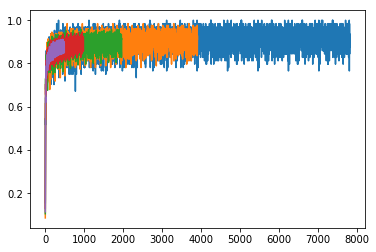

In [25]:
bz=[64,128,256,512, 1024]
for size in bz:
    train_dl=DataLoader(train_ds,batch_size=size)
    lr=.02
    epochs=10
    model=Mnist_Logistic()
    accu=[]
    import time
    start=time.time()
    for epoch in range(epochs):
        for xb,yb in train_dl:
            xb=xb
            yb=yb
            pred=model(xb)
            loss=loss_func(pred,yb)
            loss.backward()
            model.opt.step()
            model.opt.zero_grad()
            acc=accuracy(pred,yb)
            accu.append(acc)
    plt.plot(accu)
    print(f"CPU at batchsize {size} runtime is {time.time()-start}")

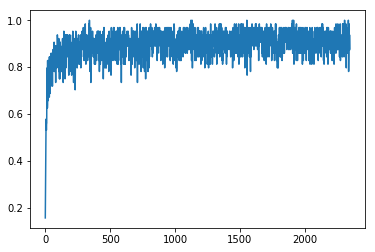

In [58]:
plt.plot(accu)

In [65]:

   
from torch.nn import functional as F
loss_func=F.cross_entropy 


batches=get_batch(batch_size,x_train,y_train)
xb,yb=next(batches)


In [90]:
lr=.1

In [91]:
model=Mnist_Logistic()

for i in range(100):
    xb,yb=next(batches)
    preds=model(xb)
    loss=loss_func(preds,yb)
    loss.backward()

    with torch.no_grad():
        for p in model.parameters(): p -= p.grad*lr
        model.zero_grad()

    print(loss)


tensor(2.3273, grad_fn=<NllLossBackward>)
tensor(2.2372, grad_fn=<NllLossBackward>)
tensor(2.1265, grad_fn=<NllLossBackward>)
tensor(2.0824, grad_fn=<NllLossBackward>)
tensor(1.9893, grad_fn=<NllLossBackward>)
tensor(1.9351, grad_fn=<NllLossBackward>)
tensor(1.9533, grad_fn=<NllLossBackward>)
tensor(1.6799, grad_fn=<NllLossBackward>)
tensor(1.7217, grad_fn=<NllLossBackward>)
tensor(1.4899, grad_fn=<NllLossBackward>)
tensor(1.3728, grad_fn=<NllLossBackward>)
tensor(1.5605, grad_fn=<NllLossBackward>)
tensor(1.6262, grad_fn=<NllLossBackward>)
tensor(1.4648, grad_fn=<NllLossBackward>)
tensor(1.4492, grad_fn=<NllLossBackward>)
tensor(1.5126, grad_fn=<NllLossBackward>)
tensor(1.2441, grad_fn=<NllLossBackward>)
tensor(1.3573, grad_fn=<NllLossBackward>)
tensor(1.5497, grad_fn=<NllLossBackward>)
tensor(1.5734, grad_fn=<NllLossBackward>)
tensor(1.3408, grad_fn=<NllLossBackward>)
tensor(1.1282, grad_fn=<NllLossBackward>)
tensor(1.1317, grad_fn=<NllLossBackward>)
tensor(1.2203, grad_fn=<NllLossBac